In [4]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

from pathlib import Path
from astropy.nddata import CCDData
from astropy.io import fits
from ccdproc import ImageFileCollection
import ccdproc as ccdp

from astropy.nddata import CCDData
from astropy.stats import mad_std
from astropy.timeseries import BinnedTimeSeries
import astropy.units as u
from convenience_functions import show_image

# suppress warnings is not recommended :I
import warnings
warnings.filterwarnings("ignore")

bias_dir = './data/bias'
flat_dir = './data/flat'
darks_dir = './data/dark'
tzboo_dir = './data/tz_boo'
cccom_dir = './data/cc_com'

In [9]:
matplotlib.use('pgf')
matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams.update({
    'pgf.texsystem': 'pdflatex',
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

# What figures do we need
## Tables
- Bias, Dark, Flat data summary
- Comparison of fluxes from PSF, DAOSF, Aperture methods

## Figures
- Light Curves comparison (normalized)
- 

## Fit results from Yakut and Eggleton (2005)
- TZ Boo period: 0.297 [d]
- CC Com period: 0.221 [d]

Formula for fit: $$f(t) = 1 + \cos\left(\frac{2\pi}{P} (t + \phi) \right)$$

In [33]:
def lc_from_period(t, phase, period):
    return 0.5 * (1 + np.cos(2 * np.pi / period * (t - phase)))

## TZ Boo Plot

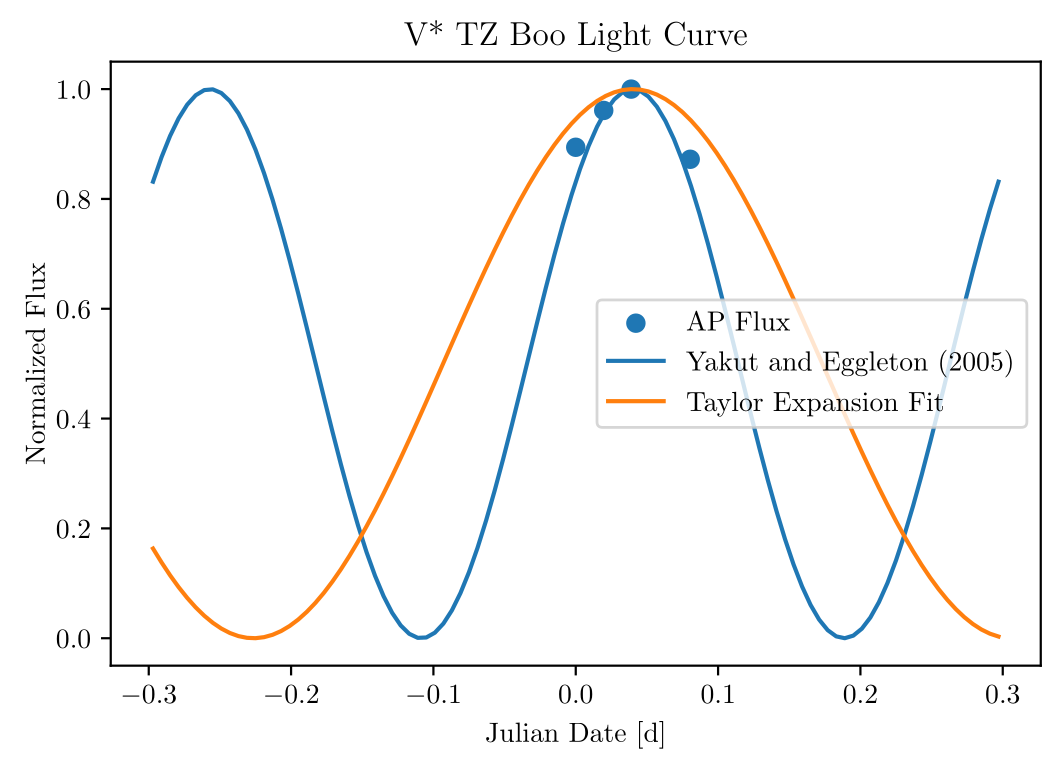

In [39]:
tz_fit = pd.read_csv('./results/tz_fit_params.csv')
tz_data = BinnedTimeSeries.read(
    './results/tzboo_results.csv',
    time_bin_start_column='time_bin_start',
    time_bin_size_column='time_bin_size',
    time_bin_size_unit=u.s
)

tz_data = {
    'time' : tz_data.time_bin_start.jd - tz_data.time_bin_start.jd.min(),
    'ap flux' : tz_data['AP flux'] / tz_data['AP flux'].max()
}

tz_period_ye = 0.297

fig, ax = plt.subplots()

fit_domain = np.linspace(-1 * tz_period_ye, 1 * tz_period_ye, 100)
tz_curve_ye = lc_from_period(fit_domain, 0.04, tz_period_ye)
tz_curve_fit = lc_from_period(fit_domain, 0.04, tz_fit['period'][0])

ax.scatter(tz_data['time'], tz_data['ap flux'], label='AP Flux')
ax.plot(fit_domain, tz_curve_ye, label='Yakut and Eggleton (2005)')
ax.plot(fit_domain, tz_curve_fit, label='Taylor Expansion Fit')
ax.legend()
ax.set_xlabel('Julian Date [d]')
ax.set_ylabel('Normalized Flux')
ax.set_title('V* TZ Boo Light Curve')

fig.savefig('../paper/figures/tz-boo_lightcurve.pgf')
# fig.savefig('../paper/figures/tz-boo_lightcurve.png')

## CC Com plot

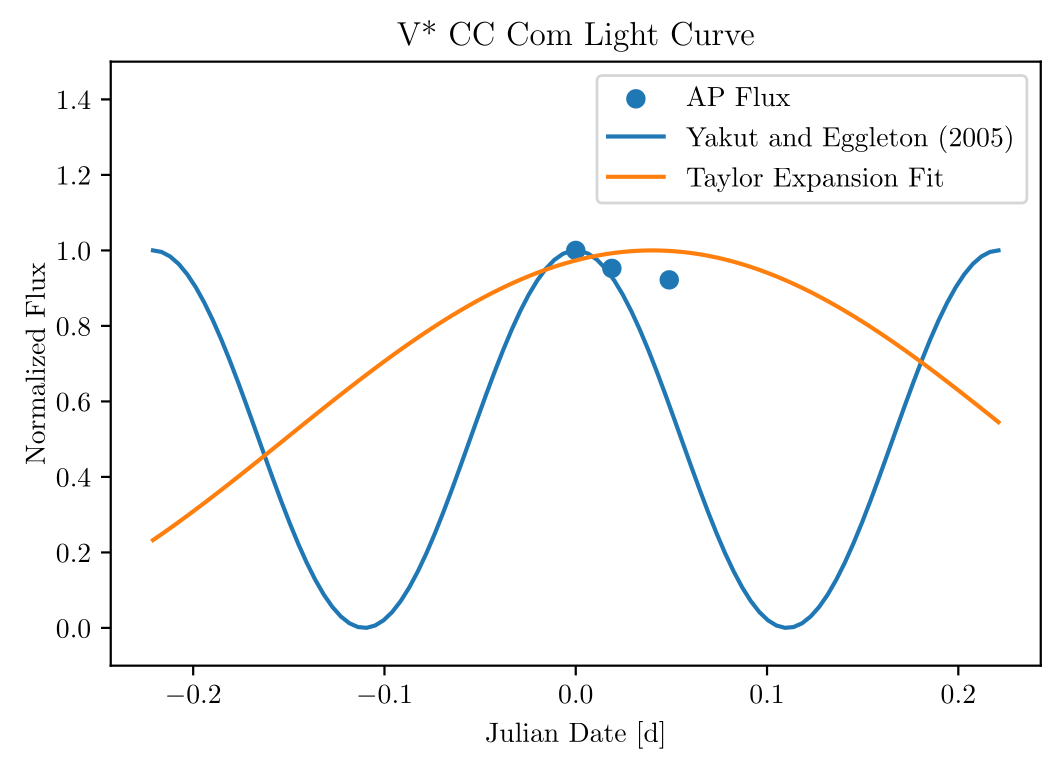

In [42]:
cc_fit = pd.read_csv('./results/cc_fit_params.csv')
cc_data = BinnedTimeSeries.read(
    './results/cccom_results.csv',
    time_bin_start_column='time_bin_start',
    time_bin_size_column='time_bin_size',
    time_bin_size_unit=u.s
)

cc_data = {
    'time' : cc_data.time_bin_start.jd - cc_data.time_bin_start.jd.min(),
    'ap flux' : cc_data['AP flux'] / cc_data['AP flux'].max()
}

cc_period_ye = 0.221

fig, ax = plt.subplots()

fit_domain = np.linspace(-1 * cc_period_ye, 1 * cc_period_ye, 100)
cc_curve_ye = lc_from_period(fit_domain, 0, cc_period_ye)
cc_curve_fit = lc_from_period(fit_domain, 0.04, cc_fit['period'][0])

ax.scatter(cc_data['time'], cc_data['ap flux'], label='AP Flux')
ax.plot(fit_domain, cc_curve_ye, label='Yakut and Eggleton (2005)')
ax.plot(fit_domain, cc_curve_fit, label='Taylor Expansion Fit')
ax.legend()
ax.set_xlabel('Julian Date [d]')
ax.set_ylabel('Normalized Flux')
ax.set_title('V* CC Com Light Curve')
ax.set_ylim([-0.1, 1.5])

fig.savefig('../paper/figures/cc-com_lightcurve.pgf')
# fig.savefig('../paper/figures/cc-com_lightcurve.png')